In [2]:
################### Importing packages ###################

import numpy as np
import pandas as pd

# for plotting
import seaborn as sns
from pylab import *
import matplotlib.font_manager as fm
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

import os

import warnings

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

fpath = '/Users/miguelalcantar/Library/Fonts/Myriad-Pro_31655.ttf'
prop = fm.FontProperties(fname=fpath)
fname = os.path.split(fpath)[1]
axis_font = {'fontname':fname, 'fontproperties':prop}

In [3]:
def load_metadata(metadata_path, drop_types=True, file_type = 'tsv'):
    """
    load in metadata dataframe
    
    parameters
    path: string
        path to csv file containing metadata
    drop_types: boolean
        indicate whether to drop first row conatining variable types (True)
        or keep first row if it is important for subsequence analyses
    file_type: string
        indicate if tab-separated
        
    returns
    metadata_df: pandas dataframe
        dataframe containing metadata
    """
    
    if file_type == 'tsv':
        metadata_df = pd.read_csv(metadata_path, sep='\t')
    else:
         metadata_df = pd.read_csv(metadata_path)
            
    if drop_types:
        metadata_df = metadata_df.iloc[1:len(metadata_df),:]
    metadata_df = metadata_df[metadata_df['treatment-group'] != 'LL_Load']
    metadata_df = metadata_df[metadata_df['sample-id'] != '9T2']
    return(metadata_df) 

################### Importing data ###################
def load_data(path, sheet = 'PC_vals_all'):
    """
    load in B-diversity dataframe
    
    parameters
    path: string
        path to excel file containing alpha-diversity values
    sheet: string
        sheet to read in
        
    returns
    pcoA_loadings_df: pandas dataframe
        dataframe containing pcoa loadings for B-diversity analysis
    pcoA_variance_exp_df: pandas dataframe
        variance explained by each PC loading
    """
    
    pcoA_df = pd.read_excel(open(path, 'rb'), sheet_name=sheet, header=None) 
    pcoA_loadings_df = pcoA_df.copy().iloc[0:len(pcoA_df)-1,:]
    pcoA_variance_exp_df = pcoA_df.copy().iloc[len(pcoA_df)-1:,:]
    
    col_name_loadings_conversion = dict()
    col_name_var_expl_conversion = dict()
    for col_name in pcoA_loadings_df.columns:
        if col_name == 0:
            col_name_loadings_conversion.update({col_name:'sample'})
            col_name_var_expl_conversion.update({col_name:'value'})
        else:
            col_name_loadings_conversion.update({col_name: 'PC_' + str(col_name)})
            col_name_var_expl_conversion.update({col_name: 'PC_' + str(col_name)})
    pcoA_loadings_df = pcoA_loadings_df.rename(columns = col_name_loadings_conversion)
    pcoA_variance_exp_df = pcoA_variance_exp_df.rename(columns = col_name_var_expl_conversion).reset_index(drop=True)

    return(pcoA_loadings_df, pcoA_variance_exp_df)

def merge_metadata_pcoa(metadata_df, pcoa_loadings_df):
    
    """
    add metadata columns to pc loadings dataframe
    
    parameters
    metadata_df: pandas dataframe
        dataframe containing metadata
    pcoa_loadings_df: pandas dataframe
        dataframe containing PC loadings
    """
    
    metadata_sample_id = list(metadata_df['sample-id'])
    metadata_orig_index = list(metadata_df.index)
    metadata_df = metadata_df.rename(index = dict(zip(metadata_orig_index,metadata_sample_id)))

    pcoA_loadings_sample_id = list(pcoa_loadings_df['sample'])
    pcoA_loadings_orig_index = list(pcoa_loadings_df.index)
    pcoa_loadings_df = pcoa_loadings_df.rename(index = dict(zip(pcoA_loadings_orig_index,pcoA_loadings_sample_id )))

    pcoa_loadings_df = pcoa_loadings_df.reindex(metadata_df.index)
    pcoa_loadings_df['treatment-group'] = metadata_df['treatment-group']
    pcoa_loadings_df['time-point-day'] = metadata_df['time-point-day']
    pcoa_loadings_df = pcoa_loadings_df.dropna()
    pcoa_loadings_df['time-point-day'] = pcoa_loadings_df['time-point-day'].astype(str)
    return(pcoa_loadings_df)




In [4]:
def plot_pcoA(pcoa_loadings, pcoa_loadings_var_exp, subset='all', metric='bray_curtis', save=True):
    
    if subset != 'all':
        pcoa_loadings_orig = pcoa_loadings.copy()
        pcoa_loadings = pd.DataFrame()
        for group_to_keep in subset:
            pcoa_loadings = pcoa_loadings.append(pcoa_loadings_orig[pcoa_loadings_orig['treatment-group'] == group_to_keep])

    # set colors 
    light_gray = '#C0BEBE'
    red = '#EA706A'
    light_orange = '#FF9200'
    blue = '#3482F4'

    # color pallete for boxplot and stripplot
    scatter_pal = {'WT_NoAmp': light_gray, 
                'WT': red, 
                'TEM1':light_orange, 
                'spTEM1':blue}

    # order to plot results
    hue_order = ['WT_NoAmp', 
                 'WT', 
                 'TEM1', 
                 'spTEM1']
    
    treatment_groups_temp = list(unique(pcoa_loadings['treatment-group']))
   
    scatter_pal_temp = dict((k, scatter_pal[k]) for k in treatment_groups_temp)
    scatter_pal = scatter_pal_temp
    hue_order_temp = [k for k in hue_order if k in treatment_groups_temp]
    hue_order = hue_order_temp
    style_order = ['0', '1', '2','3','5', '7', '9', '12']


    # plot properties
    markers = ['o', '<', '>', '^', 'd', 's','p','*']
    scatter_kwargs = {'palette': scatter_pal, 
                      'hue_order': hue_order,
                      'style_order': style_order,
                     'markers' : markers,
                     's':20,
                     'edgecolor': 'k'}
    fig = plt.figure(figsize = (4.0,4.0), dpi=400)
    g=sns.scatterplot(x="PC_1", y="PC_2", data=pcoa_loadings, hue='treatment-group',
                               style='time-point-day', **scatter_kwargs)

    var_expl_1 = '(' + str(round(pcoa_loadings_var_exp.iloc[0,1]*100,2))+ '%)'
    var_expl_2 = '(' + str(round(pcoa_loadings_var_exp.iloc[0,2]*100,2))+ '%)'
    g.set_xlabel('Axis 1 '+var_expl_1,fontsize = 12)
    g.set_ylabel('Axis 2 ' + var_expl_2, fontsize = 12)
    g.get_xaxis().tick_bottom()  
    g.get_yaxis().tick_left() 

    g.spines['left'].set_visible(True)
    g.spines['bottom'].set_visible(True)
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)

    # PC_scatter.grid(False)
    # g.legend_.remove()
    plt.tight_layout()
#     g.legend(bbox_to_anchor=(1, 1),  ncol=1, prop={'size':14})
    plt.savefig('../figs/' + metric + '_Bdiversity_PCoA.pdf')
    plt.savefig('../figs/' + metric + '_Bdiversity_PCoA.svg')
    # plt.savefig(output_dir+"PCA_"+str(PCa)+"_"+str(PCb)+metab_subset+".png")




## Bray-curtis all

In [4]:
metadata_path = '../data/metadata_and_manifest/Blactam_metadata_ds1.tsv'
metadata_df = load_metadata(metadata_path, drop_types=True, file_type = 'tsv')
bray_curtis_pcoa_path = '../data/bray_curtis_pcoA_ds1.xlsx'
bray_curtis_pcoa_loadings_df, bray_curtis_pcoa_var_exp_df = load_data(bray_curtis_pcoa_path, sheet = 'PC_vals_all')
bray_curtis_pcoa_loadings_df = merge_metadata_pcoa(metadata_df, bray_curtis_pcoa_loadings_df)

bray_curtis_pcoa_var_exp_df_to_append = bray_curtis_pcoa_var_exp_df.copy().rename(columns={'value': 'sample'})
bray_curtis_pcoa_var_exp_df_to_append['time-point-day'] = 'NA'
bray_curtis_pcoa_var_exp_df_to_append['treatment-group'] = 'NA'
bray_curtis_pcoa_loadings_df.append(bray_curtis_pcoa_var_exp_df_to_append.reset_index(drop=True), sort=False).to_csv('../data/beta_diversity_dataframes/bray_curtis_pcoa_loadings_all.csv')




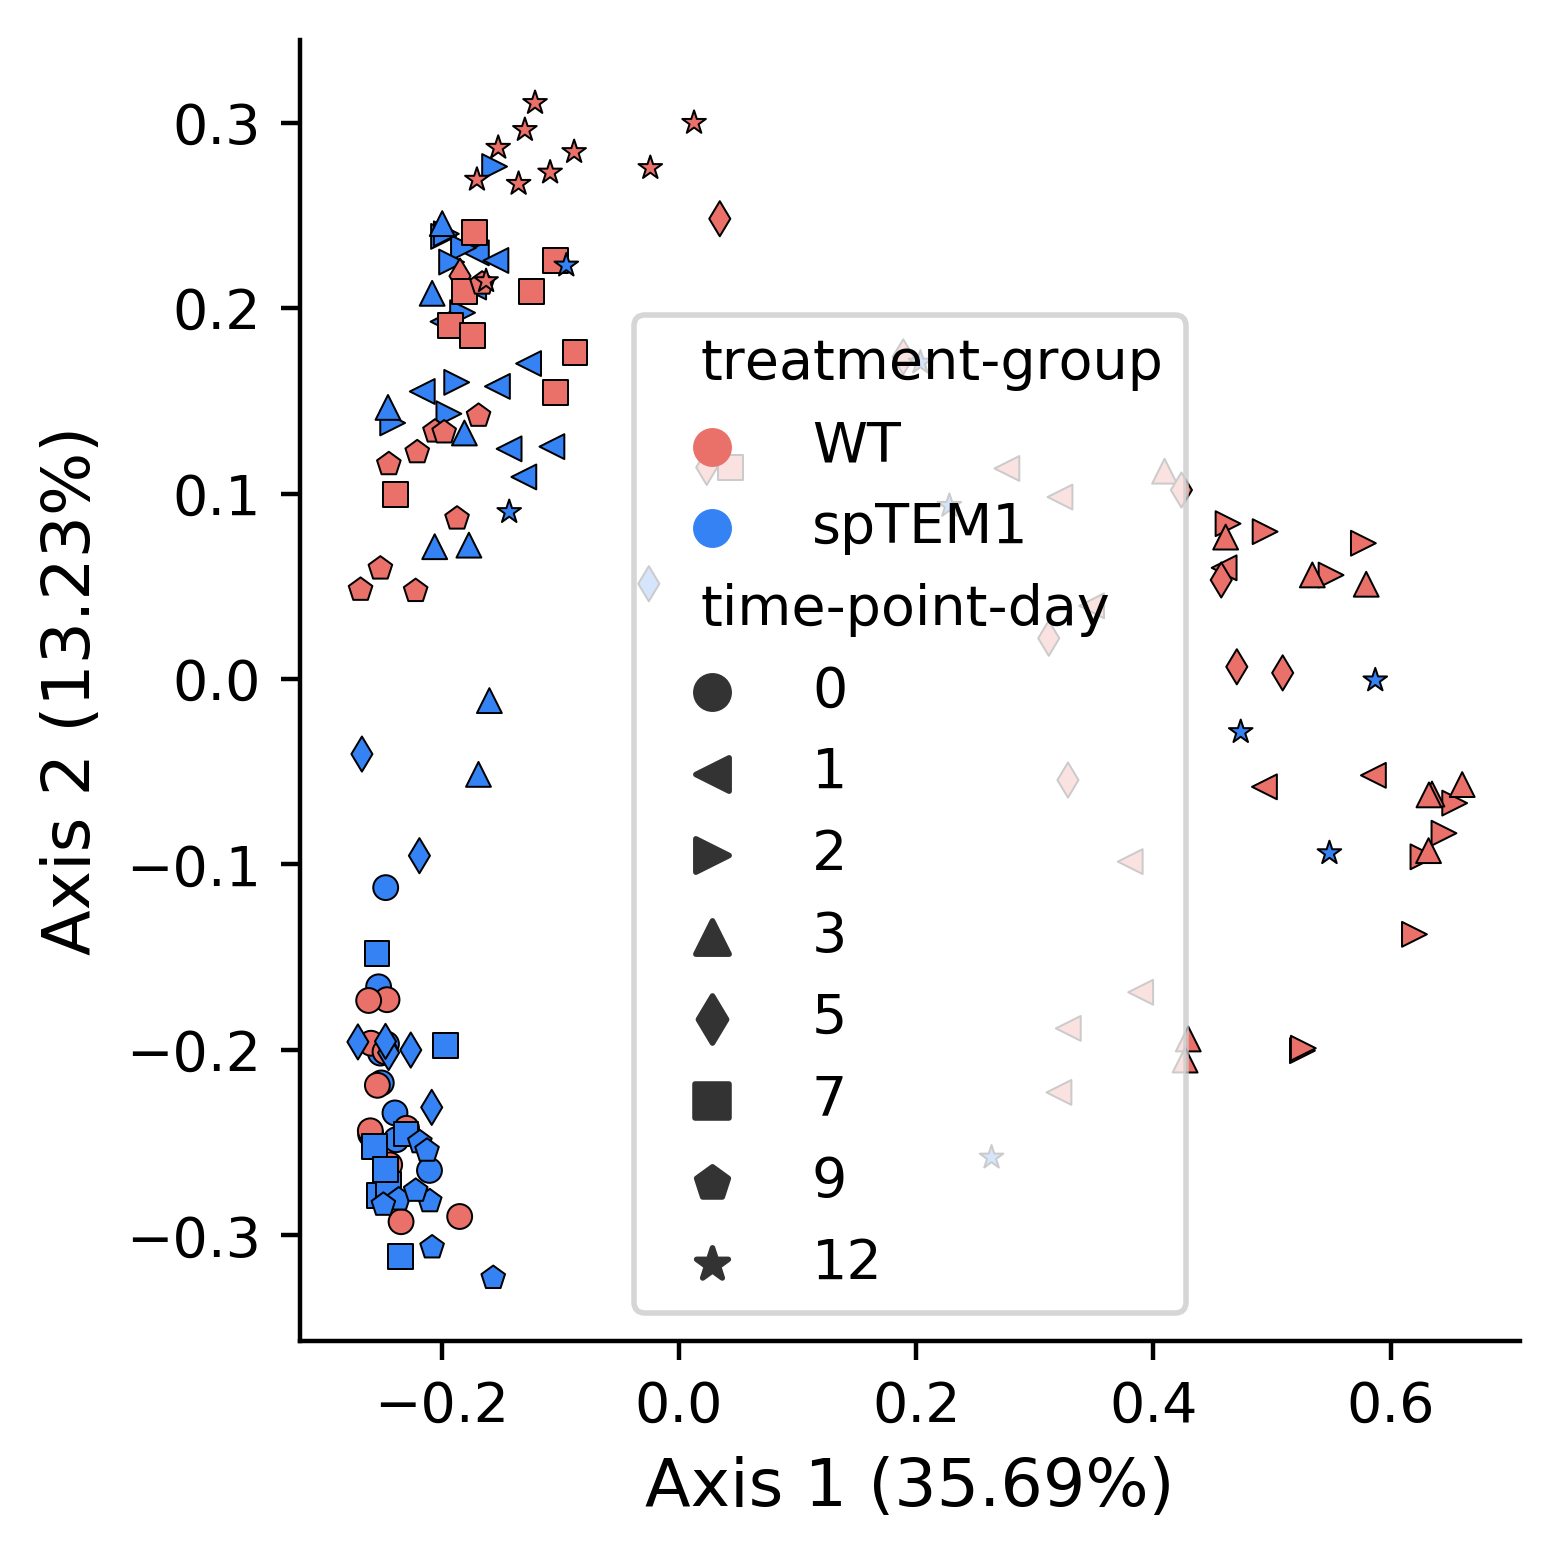

In [5]:
plot_pcoA(bray_curtis_pcoa_loadings_df, bray_curtis_pcoa_var_exp_df, metric='bray_curtis', save=True)

In [7]:
metadata_path = '../data/metadata_and_manifest/Blactam_metadata_ds1.tsv'
metadata_df = load_metadata(metadata_path, drop_types=True, file_type = 'tsv')
bray_curtis_pcoa_path_no_post_amp = '../data/bray_curtis_pcoA_subset_SpTEM1_WT_exclude_post_amp_ds1.xlsx'
bray_curtis_pcoa_loadings_no_post_amp_df, bray_curtis_pcoa_var_exp_no_post_amp_df = load_data(bray_curtis_pcoa_path_no_post_amp, sheet = 'PC_vals_all')
bray_curtis_pcoa_loadings_no_post_amp_df = merge_metadata_pcoa(metadata_df, bray_curtis_pcoa_loadings_no_post_amp_df)

bray_curtis_pcoa_var_exp_no_post_amp_df_to_append = bray_curtis_pcoa_var_exp_no_post_amp_df.copy().rename(columns={'value': 'sample'})
bray_curtis_pcoa_var_exp_no_post_amp_df_to_append['time-point-day'] = 'NA'
bray_curtis_pcoa_var_exp_no_post_amp_df_to_append['treatment-group'] = 'NA'
bray_curtis_pcoa_loadings_no_post_amp_df.append(bray_curtis_pcoa_var_exp_no_post_amp_df_to_append.reset_index(drop=True), sort=False).to_csv('../data/beta_diversity_dataframes/bray_curtis_pcoa_loadings_exclude_wt_post_amp.csv')




In [8]:
plot_pcoA(bray_curtis_pcoa_loadings_no_post_amp_df, bray_curtis_pcoa_var_exp_no_post_amp_df_to_append, metric='bray_curtis_exclude_wt_post_amp', save=True)

